In [ ]:
import re
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
import pandas as pd
import collections
import logging
import os
import pathlib
import strings
import sys
import time
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pickle
import urllib.request


In [ ]:
# with open('./sents_kor_in_hannanum_transformer.pkl', 'rb') as f:
#   sents_kor_in=pickle.load(f)
# with open('./sents_en_in_hannanum_transformer.pkl', 'rb') as f:
#   sents_en_in=pickle.load(f)

with open('./sents_kor_transformer.pkl', 'rb') as f:
  sents_kor_in=pickle.load(f)
with open('./sents_en_transformer.pkl', 'rb') as f:
  sents_en_in=pickle.load(f)

In [ ]:
# 서브워드텍스트인코더를 사용하여 질문과 답변을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer_kor = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sents_kor_in, target_vocab_size=2**13)
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sents_en_in, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
KOR_START_TOKEN, KOR_END_TOKEN = [tokenizer_kor.vocab_size], [tokenizer_kor.vocab_size + 1]
EN_START_TOKEN, EN_END_TOKEN = [tokenizer_en.vocab_size], [tokenizer_en.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
KOR_VOCAB_SIZE = tokenizer_kor.vocab_size+2
EN_VOCAB_SIZE = tokenizer_en.vocab_size + 2

In [ ]:
MAX_LENGTH = 50

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    # sentence1 = KOR_START_TOKEN+ tokenizer_kor.encode(sentence1)+ KOR_END_TOKEN
    sentence1 = KOR_START_TOKEN + tokenizer_kor.encode(sentence1)+ KOR_END_TOKEN
    sentence2 = EN_START_TOKEN + tokenizer_en.encode(sentence2) + EN_END_TOKEN
 
    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

questions, answers = tokenize_and_filter(sents_kor_in, sents_en_in)

In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(KOR_VOCAB_SIZE))
print('단어 집합의 크기(Vocab size): {}'.format(EN_VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8203
단어 집합의 크기(Vocab size): 8256
전체 샘플의 수(Number of samples): 200000


In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 0 ~ d_model
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    
    pos_encoding = tf.constant(angle_rads)
    print(pos_encoding.shape)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용 -> 어텐션에서 패딩 토큰 제외
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) #  Lower triangular part.
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # y_true가 0(패딩이면) -> 0 , 1이면 -> 1
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss) #Computes the mean of elements across dimensions of a tensor.

# loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
#     from_logits=True, reduction='none')

# def loss_function(real, pred):
#   mask = tf.math.logical_not(tf.math.equal(real, 0))
#   loss_ = loss_object(real, pred)

#   mask = tf.cast(mask, dtype=loss_.dtype)
#   loss_ *= mask

#   return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

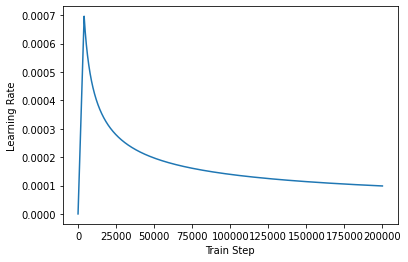

In [ ]:
sample_learning_rate = CustomSchedule(d_model=516)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# tf.keras.backend.clear_session()

# # Hyper-parameters
# NUM_LAYERS = 2
# D_MODEL = 256
# NUM_HEADS = 8
# DFF = 512
# DROPOUT = 0.1

# model = Transformer(
#     vocab_size=KOR_VOCAB_SIZE,
#     num_layers=NUM_LAYERS,
#     dff=DFF,
#     d_model=D_MODEL,
#     num_heads=NUM_HEADS,
#     dropout=DROPOUT)

In [ ]:
def Transformer(vocab_size_kor,vocab_size_en, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

##################################################################

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size_kor, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size_en, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size_en, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
DFF = 512
# DROPOUT = tf.constant(0.1,dtype=tf.float32)
DROPOUT = 0.1

model = Transformer(
    vocab_size_kor=KOR_VOCAB_SIZE,
    vocab_size_en=EN_VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(8203, 512)
(1, 8203, 512)
(8256, 512)
(1, 8256, 512)


In [ ]:
MAX_LENGTH = 50

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 5
# with tf.device('/GPU:0'):
model.fit(dataset, epochs=EPOCHS)

Epoch 1/5
3125/3125 [==============================] - 387s 124ms/step - loss: 0.9210 - accuracy: 0.1418
Epoch 2/5
3125/3125 [==============================] - 386s 124ms/step - loss: 0.7668 - accuracy: 0.1585
Epoch 3/5
3125/3125 [==============================] - 385s 123ms/step - loss: 0.6821 - accuracy: 0.1691
Epoch 4/5
3125/3125 [==============================] - 385s 123ms/step - loss: 0.6235 - accuracy: 0.1771
Epoch 5/5
3125/3125 [==============================] - 386s 123ms/step - loss: 0.5789 - accuracy: 0.1834


In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  # sentence = tf.expand_dims(
  #     START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
  sentence = tf.expand_dims(
      KOR_START_TOKEN + tokenizer_kor.encode(sentence) + KOR_END_TOKEN, axis=0)
  output = tf.expand_dims(EN_START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, EN_END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode(
      [i for i in prediction if i < EN_VOCAB_SIZE and not i==EN_END_TOKEN[0] and not i==EN_START_TOKEN[0]])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
print(tokenizer_en.decode(EN_START_TOKEN))

ValueError: Received id 8254 which is invalid. Ids must be within [0, 8254).

In [ ]:
with tf.device('/GPU:0'):
    model.save('k2eTransformer.ckpt')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb5 in position 237: invalid start byte

In [ ]:
print(sents_en_in[0])
encoded=tokenizer_en.encode(sents_en_in[0])
print(encoded)
print(tokenizer_en.decode(encoded))

Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible .
[4141, 469, 4911, 1297, 361, 254, 8, 6, 1189, 44, 1354, 15, 4819, 7, 4, 414, 416, 3669, 11, 2, 4141, 557, 1]
Bible Coloring' is a coloring application that allows you to experience beautiful stories in the Bible .


In [ ]:
output = predict('영화 볼래?')

Input: 영화 볼래?
Output: Would you like to see a movie ?


In [ ]:
output = predict('내가 만든 파스타 먹어 볼래?')
print(output)

Input: 내가 만든 파스타 먹어 볼래?
Output: Would you like to try pasta I made ?
Would you like to try pasta I made ?


In [ ]:
output = predict('추석때 만나서 한잔 할 사람?')

Input: 추석때 만나서 한잔 할 사람?
Output: Do you have a drink when you spend Chuseok ?


In [ ]:
output = predict('양파즙 개좋아')

Input: 양파즙 개좋아
Output: I like onions and running .


In [ ]:
output = predict('저는 오늘 할일이 많아서')

Input: 저는 오늘 할일이 많아서
Output: I have a lot of work to do .


In [ ]:
!gdown --id 19Dl6inqAsmKz_JKWhIufL4OTm2j6D9uV

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Dl6inqAsmKz_JKWhIufL4OTm2j6D9uV
To: /content/k2e_target.csv
100% 7.25k/7.25k [00:00<00:00, 10.4MB/s]


In [ ]:
df = pd.read_csv('k2e_target.csv')

In [ ]:
dic={
    '한글':df['한글'],
    'English':[]
}
for i in df['한글']:
  dic['English'].append(predict(i))

df_dic= pd.dataframe(dic)
df_dic.to_csv('번역결과3.csv')

Input: 정리가 필요하겠네요.
Output: I need to keep up with my seat .
Input: 처음 만났을 때를 떠올려 보세요
Output: Please leave when you first met .
Input: 구썸남 인스타에 좋아요 누름.
Output: It's good to be in Gukan .
Input: 있었던 일을 차분히 생각해봐요.
Output: Let's think about what happened in the future .
Input: 많이 찍다보면 조금씩 실력이 늘거예요.
Output: I will improve little by little by little by little when I take a picture .
Input: 가능하면 참석하는 게 좋겠죠.
Output: I hope we can participate if possible .
Input: 비밀연애가 말도 못하고 힘들죠.
Output: It's hard to talk without a secret .
Input: 자신을 너무 비난하지 마세요.
Output: Don't be too critical .
Input: 한가지만 보면 몰라요.
Output: I don't know if I look at it .
Input: 당신이 덜 다치는 쪽으로 하세요.
Output: Please take the way you are not going to work .
Input: 전 다른 일을 많이 벌려요. 정신없이 바쁘면 잊혀지더라고요.
Output: I forgot to make other tasks without any physical strength .
Input: 나중에 후회할 거예요.
Output: I will regret later .
Input: 장마인데 건조기 사는게 좋을까
Output: It's a dry end of the dry sauna .
Input: 뜻대로 되는게 많지 않죠.
Output: There are not many things